In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

import unittest

from gbgpu.gbgpu import GBGPU

from gbgpu.utils.constants import *

import tdi

## Setup all the parameters and arrays to be used in these examples

In [2]:
dt = 15.0
Tobs = 4.0 * YEAR
gb = GBGPU()

# number of points
N = int(1024)

# number of binaries to batch
num_bin = 10

# parameters
amp = 2e-19  # amplitude
f0 = 2e-3  # f0
fdot = 1e-14  # fdot
fddot = 0.0 ## not included (place holder for future?)
phi0 = 0.1  # initial phase
iota = 0.2  # inclination
psi = 0.3  # polarization angle
lam = 0.4  # ecliptic longitude
beta_sky = 0.5  # ecliptic latitude
e1 = 0.2  # eccentricity of inner binary
beta1 = 0.5  # TODO: fill in
A2 = 18.0  # third body amplitude parameter
omegabar = 0.0  # omegabar parameter
e2 = 0.3  # eccentricity of third body
P2 = 0.6  # period of third body
T2 = 0.0  # time of periapsis passage of third body

# for batching
amp_in = np.full(num_bin, amp)
f0_in = np.full(num_bin, f0)
fdot_in = np.full(num_bin, fdot)
fddot_in = np.full(num_bin, fddot)
phi0_in = np.full(num_bin, phi0)
iota_in = np.full(num_bin, iota)
psi_in = np.full(num_bin, psi)
lam_in = np.full(num_bin, lam)
beta_sky_in = np.full(num_bin, beta_sky)
e1_in = np.full(num_bin, e1)
beta1_in = np.full(num_bin, beta1)
A2_in = np.full(num_bin, A2)
P2_in = np.full(num_bin, P2)
omegabar_in = np.full(num_bin, omegabar)
e2_in = np.full(num_bin, e2)
T2_in = np.full(num_bin, T2)

length = int(Tobs / dt)

# prepare fake data for likelihood calculation
freqs = np.fft.rfftfreq(length, dt)
data_stream_length = len(freqs)

data = [
    1e-24 * np.ones(data_stream_length, dtype=np.complex128),
    1e-24 * np.ones(data_stream_length, dtype=np.complex128),
]

noise_factor = [
    np.ones(data_stream_length, dtype=np.float64),
    np.ones(data_stream_length, dtype=np.float64),
]


## Circular Galactic Binary

In [3]:
params_circ = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

gb.run_wave(*params_circ, N=N, dt=dt, modes=np.array([2]), T=Tobs)

A = gb.A[0][0]
freqs = gb.freqs[0][0]

df = 1/Tobs

snr = np.sqrt(4 * df * np.sum(A.conj() * A/tdi.noisepsd_AE(freqs)).real)

print('snr:', snr)

snr: 48.043692824525195


In [4]:
params_circ = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

num = 100

A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    modes=np.array([2]),
    N=N,
    dt=dt,
    T=Tobs,
)

st = time.perf_counter()
for _ in range(num):
    like = gb.get_ll(
        params_circ, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
    )
et = time.perf_counter()
print("circ:", (et - st) / num, "per binary:", (et - st) / (num * num_bin))


circ: 0.004381067860000001 per binary: 0.00043810678600000007


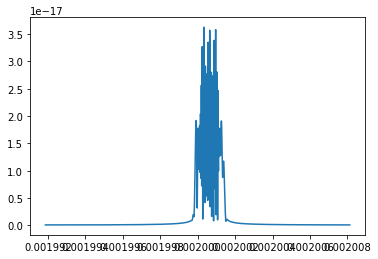

In [5]:
plt.plot(gb.freqs[0][0], np.abs(gb.A[0][0]))

In [6]:

params_ecc = np.array(
    [
        amp_in,
        f0_in,
        fdot_in,
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        e1_in,
        beta1_in,
    ]
)

modes = np.array([1, 2, 3, 4])
A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    e1,
    beta1,
    modes=modes,
    N=N,
    dt=dt,
    T=Tobs,
)

st = time.perf_counter()
for _ in range(num):
    like = gb.get_ll(params_ecc, [A_inj, E_inj], noise_factor, N=N, dt=dt, modes=modes, T=Tobs,)
et = time.perf_counter()
print(
    "ecc ({} modes):".format(len(modes)),
    (et - st) / num,
    "per binary:",
    (et - st) / (num * num_bin),
)


ecc (4 modes): 0.040176912589999995 per binary: 0.004017691259


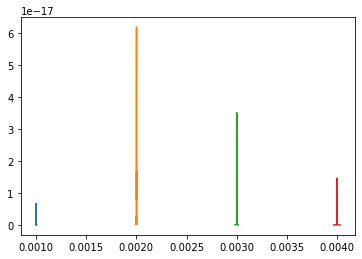

In [7]:
for i in range(len(modes)):
    plt.plot(gb.freqs[i][0], np.abs(gb.A[i][0]))

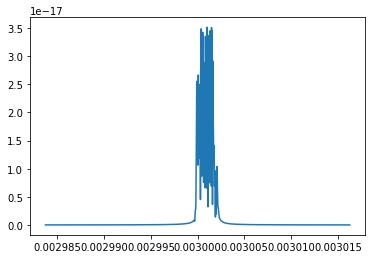

In [8]:
# zoom in on j = 3 mode
plt.plot(gb.freqs[2][0], np.abs(gb.A[2][0]))

In [9]:
params_circ_third = np.array(
    [
        amp_in,
        f0_in,
        fdot_in,
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        A2_in,
        omegabar_in,
        e2_in,
        P2_in,
        T2_in,
    ]
)

A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    A2,
    omegabar,
    e2,
    P2,
    T2,
    modes=np.array([2]),
    N=N,
    dt=dt,
    T=Tobs,
)

st = time.perf_counter()
for _ in range(num):
    like = gb.get_ll(
        params_circ_third, [A_inj, E_inj], noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
    )
et = time.perf_counter()
print("circ / third:", (et - st) / num, "per binary:", (et - st) / (num * num_bin))


circ / third: 0.014745362300000009 per binary: 0.0014745362300000008


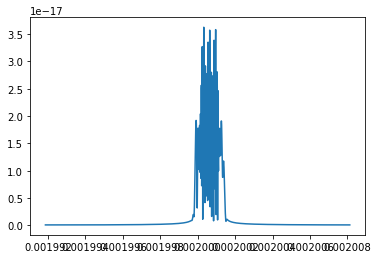

In [10]:
plt.plot(gb.freqs[0][0], np.abs(gb.A[0][0]))

In [11]:
params_full = np.array(
    [
        amp_in,
        f0_in,
        fdot_in,
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        e1_in,
        beta1_in,
        A2_in,
        omegabar_in,
        e2_in,
        P2_in,
        T2_in,
    ]
)

modes = np.array([1, 2, 3, 4])
A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    e1,
    beta1,
    A2,
    omegabar,
    e2,
    P2,
    T2,
    modes=modes,
    N=N,
    dt=dt,
    T=Tobs,
)

st = time.perf_counter()
for _ in range(num):
    like = gb.get_ll(params_full, [A_inj, E_inj], noise_factor, N=N, dt=dt, modes=modes, T=Tobs,)
et = time.perf_counter()
print(
    "ecc/third ({} modes):".format(len(modes)),
    (et - st) / num,
    "per binary:",
    (et - st) / (num * num_bin),
)


ecc/third (4 modes): 0.11491968520000002 per binary: 0.011491968520000001


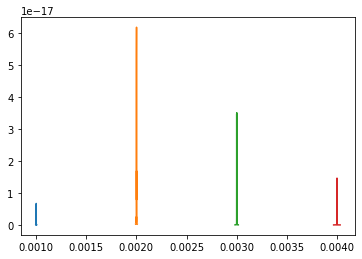

In [12]:
for i in range(len(modes)):
    plt.plot(gb.freqs[i][0], np.abs(gb.A[i][0]))

In [13]:
df = 1/(Tobs) 
fmax = 1e-2
noise_freqs = np.arange(0.0, fmax, df)[1:]

AE_noise = tdi.noisepsd_AE(noise_freqs)

noise_factor = [1/np.sqrt(AE_noise) * np.sqrt(df), 1/np.sqrt(AE_noise) * np.sqrt(df)]

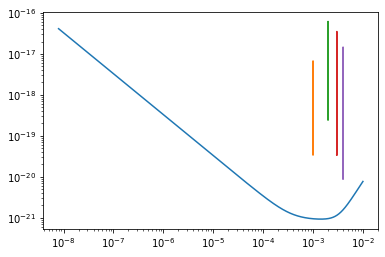

In [14]:
plt.loglog(noise_freqs, np.sqrt(AE_noise))
for i in range(len(modes)):
    plt.plot(gb.freqs[i][0], np.abs(gb.A[i][0]))

In [15]:
# inject eccentric signal

params_ecc = np.array(
    [
        amp_in,
        f0_in,
        fdot_in,
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        e1_in,
        beta1_in,
    ]
)

modes = np.array([1, 2, 3, 4])
A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    e1,
    beta1,
    modes=modes,
    N=N,
    dt=dt,
    T=Tobs,
)

A_inj = A_inj[1:len(AE_noise) + 1] / np.sqrt(AE_noise) * np.sqrt(df)
E_inj = E_inj[1:len(AE_noise) + 1] / np.sqrt(AE_noise) * np.sqrt(df)

data = [A_inj[1:], E_inj[1:]]  # right summation rule

# try to extract with ecc

like = gb.get_ll(
    params_ecc, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
)

print('ecc template log likelihood:', like)

# try to extract with circular

params_circ = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

like = gb.get_ll(
    params_circ, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
)

print('circ template log likelihood:', like)

ecc template log likelihood: [-4.83291641e-09 -4.83291641e-09 -4.83291641e-09 -4.83291641e-09
 -4.83291641e-09 -4.83291641e-09 -4.83291641e-09 -4.83291641e-09
 -4.83291641e-09 -4.83291641e-09]
circ template log likelihood: [-16655.82888649 -16655.82888649 -16655.82888649 -16655.82888649
 -16655.82888649 -16655.82888649 -16655.82888649 -16655.82888649
 -16655.82888649 -16655.82888649]


In [16]:
# inject circular with eccentric third body

A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    A2,
    omegabar,
    e2, 
    P2, 
    T2,
    modes=modes,
    N=N,
    dt=dt,
    T=Tobs,
)

A_inj = A_inj[1:len(AE_noise) + 1] / np.sqrt(AE_noise) * np.sqrt(df)
E_inj = E_inj[1:len(AE_noise) + 1] / np.sqrt(AE_noise) * np.sqrt(df)

data = [A_inj[1:], E_inj[1:]]  # right summation rule

# try to extract with circular third body

like = gb.get_ll(
    params_circ_third, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
)

A_third = gb.A[0][0].copy()
freqs_third = gb.freqs[0][0].copy()

print('circular third body template likelihood:', like)

# try to extract with circular

params_circ = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

like = gb.get_ll(
    params_circ, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
)

A_circ = gb.A[0][0].copy()

freqs_circ = gb.freqs[0][0].copy()

print('circ template likelihood:', like)

circular third body template likelihood: [-1.43928694e-09 -1.43928694e-09 -1.43928694e-09 -1.43928694e-09
 -1.43928694e-09 -1.43928694e-09 -1.43928694e-09 -1.43928694e-09
 -1.43928694e-09 -1.43928694e-09]
circ template likelihood: [-0.01775862 -0.01775862 -0.01775862 -0.01775862 -0.01775862 -0.01775862
 -0.01775862 -0.01775862 -0.01775862 -0.01775862]


In [17]:
snr = np.sqrt(4 * df * np.sum(A_third.conj() * A_circ/tdi.noisepsd_AE(freqs)).real)

In [18]:
snr2 = np.sqrt(4 * df * np.sum(A_third.conj() * A_third/tdi.noisepsd_AE(freqs)).real)

In [19]:
snr, snr2

(48.04360031803253, 48.04369288468867)